In [36]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
import torch.optim as optim


from Preprocessing import *
from CNN_ExtractGenre import *
from PolyphonicPreprocessing import *

import DatasetLoader as DL
import Model as M

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Cleaning data

Apply the functions in Preprocessing.py to clean the midi dataset. There are multiple files that are currupted or duplicated. 
For this analysis we are also going to use only Midi file with a timestamp of 4/4, like in the reference paper. This filtering is done in CleaningData()

In [3]:
DeleteDuplicates()
CleaningData()

100%|██████████| 2201/2201 [06:27<00:00,  5.68it/s]


The input of the model has to be a 128x16 matrix as in the paper. The following function clasify the midi tracks into instrumental classes:
- Guitar  
- Percussion
- Organ  
- Sound Effects 
- Bass  
- Piano 
- Synth Lead 
- Chromatic Percussion 
- Synth Pad  
- Percussive 
- Synth Effects
- Ethnic  

In [3]:
MonophonicDataset = PreProcessing(nDir = 2000)
torch.save(MonophonicDataset, 'MonophonicDataset.pt')

Preprocessing: 100%|██████████| 2000/2000 [07:57<00:00,  4.19it/s]


In [10]:
MonophonicDataset = torch.load('MonophonicDataset.pt', map_location='cpu')

In [11]:
for key in MonophonicDataset.keys():
   print(f"{key.ljust(25)} number of Bars: {len(MonophonicDataset[key])}")

Bass                      number of Bars: 106314
Ensemble                  number of Bars: 53067
Organ                     number of Bars: 37496
Guitar                    number of Bars: 176320
Piano                     number of Bars: 48277
Synth Lead                number of Bars: 18727
Percussive                number of Bars: 4689
Synth Effects             number of Bars: 6506
Reed                      number of Bars: 28849
Brass                     number of Bars: 31106
Synth Pad                 number of Bars: 13475
Pipe                      number of Bars: 16226
Strings                   number of Bars: 27713
Sound Effects             number of Bars: 7644
Chromatic Percussion      number of Bars: 25030
Percussion                number of Bars: 3890
Ethnic                    number of Bars: 2970


### N.B.

in order to save disk memory the 128x16 matrix are stored as sparse matrix since the majority of the element of the matricies are zeros.
In the next cell we are showing how the dataset is done: the dataset is diveded into the instruments classes and each class is a list of bars. Each list contains the SongName, a tuple containing ($Bar_{i-1}$, $Bar_{i}$), the Program (which correspond to the instrument played, see **Util.py**), the Channel of the song (superfluous), the number of the bar (superfluous) and the Tempo of the song.

In [ ]:
#First element of the Bass instruments. There are all the possible information needed
MonophonicDataset['Bass'][0]

{'SongName': ("It's a Real Good Feeling", "It's a Real Good Feeling"),
 'Bars': (tensor(indices=tensor([[29, 29, 29, 29, 29, 29, 36, 36, 36, 36, 36, 36, 36, 36,
                          38, 38, 38, 38],
                         [ 0,  1,  2,  3,  4,  5,  5,  6,  7, 11, 12, 13, 14, 15,
                           8,  9, 10, 11]]),
         values=tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
         size=(128, 16), nnz=18, dtype=torch.int32, layout=torch.sparse_coo),
  tensor(indices=tensor([[34, 34, 34, 34, 34, 34, 41, 41, 41, 41, 41, 41, 41, 43,
                          43, 43, 43],
                         [ 0,  1,  2,  3,  4,  5,  6,  7,  8, 12, 13, 14, 15,  8,
                           9, 10, 11]]),
         values=tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
         size=(128, 16), nnz=17, dtype=torch.int32, layout=torch.sparse_coo)),
 'Program': 35,
 'Channel': (1, 1),
 'numBar': (2, 3),
 'Tempo': (123, 123)}

In [ ]:
#Since we load it after, we free some space
del MonophonicDataset
gc.collect()

# Genre detection using CNN

The idea is to train a Convolutional Neural Network (CNN) to understand the structure of the songs and to implement a classifier capable of identifying the genre of each song in our MIDI dataset.

However, we cannot train the CNN directly on our MIDI dataset, since this would compromise both learning and classification. Moreover, CNNs are supervised learning models, and our dataset does not include genre labels. For this reason, we found another dataset containing 100 songs in .wav format for each of the following musical genres:

- metal
- disco
- classical
- hiphop
- jazz
- country
- pop
- blues 
- raggae 
- rock

The idea is to train the CNN using this labeled dataset. Before doing that, we need to perform some preprocessing, since some songs in the dataset are corrupted. Additionally, the audio clips are only a few seconds long, so we preprocess each song to have a fixed length and a consistent format. The preprocessing functions are implemented in the file **CNN_ExtractGenre.py**.

After preprocessing, we define the CNN model and the data loader in **Model.py** and **DataLoader.py**, respectively. The model is trained on Google Colab (not on the local machine), and we later load the trained model using its state_dict.

The CNN achieves a strong validation accuracy of 84%, as shown in the accompanying paper.

Once the model is trained on the labeled dataset, we use it to classify our own songs. This is a complex process because our songs are in .mid format, while the model expects .wav spectrograms as input. Therefore, each MIDI file must be converted into audio, transformed into a spectrogram, and then classified by the CNN.


N.B. all the function in the file **CNN_ExtractGenre** has already been runned since the computation is quite long. In the following cell we are showing the final result

In [23]:
#Load the preprocessed and classified dataset:
with open('GenreDataset.pkl', 'rb') as f:
   GenreDataset = pickle.load(f)

#Mapping each genre into a number for classification
GenreMapping = {'metal': 0, 'disco': 1, 'classical': 2, 'hiphop': 3, 'jazz': 4,
          'country': 5, 'pop': 6, 'blues': 7, 'reggae': 8, 'rock': 9}

i = 0
for key in GenreDataset.keys():
   i += 1
   genre, prob = GenreDataset[key]
   print(f"{'Song name:':<10} {key.ljust(60)} {'Genre and probability:':<25} ({genre}, {prob:.2f})")

   if i > 10:
      break


Song name: Gordon Lightfoot/Sundown                                     Genre and probability:    (9, 0.50)
Song name: Gordon Lightfoot/Sundown.1                                   Genre and probability:    (9, 1.00)
Song name: Gordon Lightfoot/Rainy Day People                            Genre and probability:    (9, 0.50)
Song name: Gordon Lightfoot/Carefree Highway                            Genre and probability:    (9, 0.92)
Song name: Gordon Lightfoot/Beautiful                                   Genre and probability:    (4, 0.67)
Song name: Gounod Charles/Ave Maria.1                                   Genre and probability:    (2, 0.92)
Song name: Gounod Charles/Marche funebre d'une marionnette              Genre and probability:    (2, 0.42)
Song name: Gounod Charles/Waltz from Faust                              Genre and probability:    (2, 1.00)
Song name: Grace Jones/Slave to the Rhythm                              Genre and probability:    (6, 0.58)
Song name: Grand Funk Railro

# Polyphonic Music Generator

as now we are only considering monophonic tracks, we are thus losing all the information between notes of the same instrument and the correlation between instruments! Therefore we would like to try to implement a polyphonic music generator. 

The strategy is the same as before. Instead of having (128x16) matrix we have (4x128x16) where 4 is the maximum number of instruments that can be played at the same time. Now each matrix 128x16 does not encode for a single note as before, but it allows for multiple note of the same instrument.

In the file **PolyphonicPreprocessing.py** there are all the function used to preprocess the clean_midi dataset and build the dataset of mapped songs. Here we are processing and storing the Polyphonic dataset

In [2]:
PolyphonicDataset = PolyphonicPreProcessing(nDir = 2000)
torch.save(PolyphonicDataset, 'PolyphonicDataset.pt')

Preprocessing: 100%|██████████| 2000/2000 [06:14<00:00,  5.35it/s]


3143


And these are all the genre and the number of bars for each genre

In [20]:
PolyphonicDataset = torch.load('PolyphonicDataset.pt', weights_only=False)

As before the 4x128x16 matrix is stored as a sparse matrix to save space. There is also the informationa about the genre of the song.

In [21]:
PolyphonicDataset[0]

{'SongName': ('The Righteous Brothers/Unchained Melody.3',
  'The Righteous Brothers/Unchained Melody.3'),
 'Bars': (tensor(indices=tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
                           0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
                           1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
                           1,  1],
                         [31, 33, 33, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36,
                          36, 36, 35, 35, 35, 35, 35, 35, 35, 35, 37, 37, 37, 37,
                          42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42,
                          42, 42],
                         [ 6,  6,  7,  0,  1,  2,  3,  4,  5,  8,  9, 10, 11, 12,
                          13, 14,  0,  1,  6,  7,  8,  9, 14, 15,  4,  5, 12, 13,
                           0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13,
                          14, 15]]),
         values=tensor([1, 1, 1, 1, 1, 1

In [ ]:
del PolyphonicDataset
gc.collect()

# Monophonic and Polyphonic Model and Architecture

In [11]:
#Choose if the training is done with the Monophonic Dataset or Polyphonic Dataset
Mono = False

EPOCHS = 20
noise_dim = 100
BATCH_SIZE = 70

if Mono:
                              #Train the network on these instruments
  Data = DL.MonophonicDataset(Instruments=['Piano', 'Guitar', 'Bass'])
  dataloader = DataLoader(Data, BATCH_SIZE, shuffle=True, num_workers=0, drop_last=True)

else: Data = DL.PolyphonicDataset()

In [18]:
if torch.cuda.is_available():
   device = torch.device("cuda")
   print('GPU available')

elif torch.backends.mps.is_available():
   device = torch.device('mps')
   print('mps available')
else:
   device = torch.device("cpu")
   print('GPU not available')

mps available


### Concatenation

Definition of the concatenation functions that are used in the hidden layers to concatenate the output and the 1_d and 2_d conditions.

1_d conditioning vector of shape $[n,1]$ with an output of shape $[batch,features,a,b]$:
* first we have to duplicate the vector $a\cdot b$ times to get a tensor of shape $[batch,n,a,b]$
* then we can concatenate the two tensors in the depth dimension (i.e dim=1)

2_d conditioning matrix of the same shape of the output $[batch,features,a,b]$ except the depth dim (it must be that because how we build the conditioner CNN):
* first we check that the dimensions are correct
* we concatenate the two tensors in the depth dimension (i.e dim=1)

In [6]:
def conv_cond_concat(x, y):
    """Concatenate conditioning vector on feature map axis."""
    x_shapes = x.shape  #[batch,n_features,a,b]
    y_shapes = y.shape  #[batch,n]
    y2 = y.view(x_shapes[0],y_shapes[1],1,1)                              #[batch,n,1,1]
    y2 = y2.expand(x_shapes[0],y_shapes[1],x_shapes[2],x_shapes[3])      #[batch,n,a,b]

    return torch.cat((x, y2),dim=1)                                     #[batch,n_features+n,a,b]

def conv_prev_concat(x, y):
    """Concatenate conditioning vector on feature map axis."""
    x_shapes = x.shape  #[batch,n_features,a,b]
    y_shapes = y.shape  #[batch,16,a,b]
    if x_shapes[2:] == y_shapes[2:]:
        y2 = y.expand(x_shapes[0],y_shapes[1],x_shapes[2],x_shapes[3])  #[batch,16,a,b]

        return torch.cat((x, y2),dim=1)                                 #[batch,n_features+16,a,b]

    else:
        print(x_shapes[2:])
        print(y_shapes[2:])

### The Generator and the Conditioner

The generator uses `ConvTranspose2d` (upsampling) layers to produce an image from a seed (random noise). Start with two `Dense` layers that take this seed as input and transform it to a tensor of shape $[\text{batch size}, 128, 1, 2]$, then upsample several times until we reach the desired size of a bar of $[\text{instrument}, 128, 16]$. We use  the `ReLU` activation for each layer, except the output layer which can use `Sigmoid` to predict pixel values in the [0, 1] range.

Coupled to the generator there is the conditioner that uses `Conv2d` (sampling) layers to produce the 2_d tensors that serve as informations from the preaviou bar. The conditioner can be viewed as the reverse of the generator because it uses filters with the same shapes of the ones in the generator. In this case we use  the `LeakyReLU` activation for each layer.

In [4]:
class Generator(nn.Module):

   def __init__(self, input_size, cond_1d_size, instrument_size=1, n_hlayers=128):
      super().__init__()

      self.input_size = input_size
      self.instrument_size = instrument_size
      self.cond1d_dim = cond_1d_size

      #generator layers
      #as said in the DCGAN paper always ReLU activation function in the generator excluded the last layer
      #as said in the DCGAN paper always batchnorm iin the generator excluded the last layer
      self.ff1 = nn.Sequential(
         nn.Linear(input_size+cond_1d_size, 1024),                                                                                     #[batch,1024]
         nn.BatchNorm1d(1024),
         nn.ReLU()
         )
      self.ff2 = nn.Sequential(
         nn.Linear(1024+cond_1d_size,n_hlayers*2),                                                                                    #[batch,512]
         nn.BatchNorm1d(n_hlayers*2),
         nn.ReLU()
         )
      #reshape to [batch size,128,1,2]
      # #+condition [batch,128+cond_1d_size+16,1,2]
      self.cnn1 = nn.Sequential(
         nn.ConvTranspose2d(n_hlayers+cond_1d_size+16, n_hlayers, kernel_size=(1,2), stride=(2,2), bias=False, padding=0),           #[batch,128,1,4]
         nn.BatchNorm2d(n_hlayers),
         nn.ReLU()
         )
      #+condition [batch,128+cond_1d_size+16,1,2]
      self.cnn2 = nn.Sequential(
         nn.ConvTranspose2d(n_hlayers+cond_1d_size+16, n_hlayers, kernel_size=(1,2), stride=(2,2), bias=False, padding=0),           #[batch,128,1,8]
         nn.BatchNorm2d(n_hlayers),
         nn.ReLU()
         )
      #+condition [batch,128+cond_1d_size+16,1,2]
      self.cnn3 = nn.Sequential(
         nn.ConvTranspose2d(n_hlayers+cond_1d_size+16, n_hlayers, kernel_size=(1,2), stride=(2,2), bias=False, padding=0),           #[batch,128,1,16]
         nn.BatchNorm2d(n_hlayers),
         nn.ReLU()
         )
      #+condition [batch,128+cond_1d_size+16,1,2]
      self.cnn4 = nn.Sequential(
         nn.ConvTranspose2d(n_hlayers+cond_1d_size+16, instrument_size, 
                           kernel_size=(128,1), stride=(2,1), bias=False, padding=0),                                      #[batch,instrument_size,128,16]
         nn.Sigmoid()
         #Sigmoid funciotn because we want to generate the matrixes of music without velocity, i.e. only (0,1)
         #Thus we use the sigmoid which is a smoother version of the sign function
         )
      #conditioner layers
      # #as in Midinet model we use the Leaky activation funciton for the conditioner
      self.h0_prev = nn.Sequential(
         nn.Conv2d(in_channels=instrument_size, out_channels=16, kernel_size=(128,1), stride=(2,1)),                  #[batch,16,1,16]
         nn.BatchNorm2d(16),
         nn.LeakyReLU()          #note: in the original paper leak=0.2, default leak=0.01
         )
      self.h1_prev = nn.Sequential(
         nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(1,2), stride=(2,2)),                                  #[batch,16,1,8]
         nn.BatchNorm2d(16),
         nn.LeakyReLU()
         )
      self.h2_prev = nn.Sequential(
         nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(1,2), stride=(2,2)),                                  #[batch,16,1,4]
         nn.BatchNorm2d(16),
         nn.LeakyReLU()
         )
      self.h3_prev = nn.Sequential(
         nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(1,2), stride=(2,2)),                                  #[batch,16,1,2]
         nn.BatchNorm2d(16),
         nn.LeakyReLU()
         )

   def forward(self, z, prev_bar, cond_1d, batch_size):

      #2d condiiton
      cond0 = self.h0_prev(prev_bar)          #[batch,16,1,16]
      cond1 = self.h1_prev(cond0)             #[batch,16,1,8]
      cond2 = self.h2_prev(cond1)             #[batch,16,1,4]
      cond3 = self.h3_prev(cond2)             #[batch,16,1,2]

      #single cond_1d size =[n,1], batch_cond_1d size = [batch_size,n]

      input = torch.cat((z,cond_1d), dim=1)   #[batch_size, input_size+cond_1d_size]

      h0 = self.ff1(input)                    #[batch,1024]
      h0 = torch.cat((h0,cond_1d), dim=1)     #[batch,1024+cond_1d_size]

      h1 = self.ff2(h0)                       #[batch,256]
      h1 = h1.reshape(batch_size, 128, 1, 2)  #[batch,128,1,2]
      h1 = conv_cond_concat(h1,cond_1d)       #[batch,128+cond_1d_size,1,2]
      h1 = conv_prev_concat(h1,cond3)         #[batch,128+cond_1d_size+16,1,2]

      h2 = self.cnn1(h1)                      #[batch,128,1,4]
      h2 = conv_cond_concat(h2,cond_1d)       #[batch,128+cond_1d_size,1,4]
      h2 = conv_prev_concat(h2,cond2)         #[batch,128+cond_1d_size+16,1,4]

      h3 = self.cnn2(h2)                      #[batch,128,1,8]
      h3 = conv_cond_concat(h3,cond_1d)       #[batch,128+cond_1d_size,1,8]
      h3 = conv_prev_concat(h3,cond1)         #[batch,128+cond_1d_size+16,1,8]

      h4 = self.cnn3(h3)                      #[batch,128,1,16]
      h4 = conv_cond_concat(h4,cond_1d)       #[batch,128+cond_1d_size,1,16]
      h4 = conv_prev_concat(h4,cond0)         #[batch,128+cond_1d_size+16,1,16]

      out = self.cnn4(h4)                     #[batch,instrument_size,128,16]

      return out

### The Discriminator

The discriminator uses `Conv2d` (sampling) layers to produce a scalar output from a bar input. Start with two `Conv2d` layers that reduce the size of the input, then use two `Dense` layers. We use  the `LeakyReLU` activation for each layer, except the output layer which can use `Sigmoid` to predict true-false probability value in the [0, 1] range. Note that the activation is included in the loss function.

In [9]:
class MinibatchDiscrimination(nn.Module):
    def __init__(self, in_features, out_features, kernel_dim):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.kernel_dim = kernel_dim
        self.T = nn.Parameter(torch.randn(in_features, out_features, kernel_dim))

    def forward(self, x):
        # x is batch_sizexA
        # T is AxBxC
        matrices = x @ self.T.view(self.in_features, -1)                     # matrix moltiplication, result shape: [batch_size, B*C]
        matrices = matrices.view(-1, self.out_features, self.kernel_dim)     #M shape [batch, B, C]

        # compute L1 distances between samples
        M = matrices.unsqueeze(0)               # [1,batch,B,C]
        M_T = M.permute(1, 0, 2, 3)             # [batch,1,B,C]
        norm = torch.abs(M - M_T).sum(3)        # first broadcast [batch,batch,B,C], then [batch,batch,B]
        cbij = torch.exp(-norm)
        o_b = cbij.sum(0)                       # [batch,B], if j !=0 i in teh sum then subtract self distance (cbij.sum(0) - 1)

        x = torch.cat([x, o_b], 1)
        return x

In [10]:
class Discriminator(nn.Module):

    def __init__(self, cond_1d_size, instrument_size=1, mini_size=100):
        super().__init__()

        self.instrument_size = instrument_size
        self.cond1d_dim = cond_1d_size

        #as said in the DCGAN paper always batchnorm in the discriminator layers excluded the first layer
        self.cnn1 = nn.Sequential(
            nn.Conv2d(2*instrument_size+cond_1d_size, 32, kernel_size=(128,2), stride=(2,2), padding=0),        #[batch,32,1,8]
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2)
        )
        #+condition [batch,14+cond_1d_size,1,8]
        self.cnn2 = nn.Sequential(
            nn.Conv2d(32+cond_1d_size, 77, kernel_size=(1,4), stride=2, padding=0),                             #[batch,77,1,3]
            #Adding residual block
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2)
        )

        self.ffnn1 = nn.Sequential(
             #+condition [batch,231+cond_1d_size]
            nn.Linear(231+cond_1d_size, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2)
        )

        self.minibatch = MinibatchDiscrimination(in_features=1024, out_features=mini_size,kernel_dim=3)

        #+condition [batch,1024+mini_size+cond_1d_size]
        #no sigmoid activation function because it is already in the definition of the cross entropy loss function
        self.ffnn2 = nn.Linear(1024+cond_1d_size+mini_size, 1)      


    def forward(self, x, prev_bar, cond_1d):
        input = conv_cond_concat(x,cond_1d)         #[batch,instrument_size+cond_1d_size,128,16]
        input = conv_prev_concat(input,prev_bar)    #[batch,2*instrument_size+cond_1d_size,128,16]

        h0 = self.cnn1(input)                       #[batch,14,1,8]
        fm = h0
        h0 = conv_cond_concat(h0, cond_1d)          #[batch,14+cond_1d_size,1,8]

        h1 = self.cnn2(h0)                          #[batch,77,1,3]
        h1 = torch.flatten(h1, 1)                   #[batch,77*3*1]
        h1 = torch.cat((h1,cond_1d),dim=1)          #[batch,231+cond_1d_size]

        h2 = self.ffnn1(h1)                         #[batch,1024]
        h2 = self.minibatch(h2)                     #[batch,1024+mini_size]
        h2 = torch.cat((h2,cond_1d),dim=1)          #[batch,1024+mini_size+cond_1d_size]

        h3 = self.ffnn2(h2)                         #[batch,1]
        h3_sigmoid = torch.sigmoid(h3)


        return h3_sigmoid, h3, fm

### Weights initialization

In [11]:
def weights_init(m):
    if isinstance(m, (nn.ConvTranspose2d, nn.Conv2d)):
        nn.init.normal_(m.weight.data, 0.0, 0.02)  # DCGAN standard
    elif isinstance(m, nn.Linear):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif isinstance(m, (nn.BatchNorm2d, nn.BatchNorm1d)):
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### Creation of Generator and Discriminator:

In [12]:
Mono = False
if Mono:
  generator = Generator(input_size=100, cond_1d_size=2, instrument_size=1, n_hlayers=128)
  discriminator = Discriminator(cond_1d_size=2, instrument_size=1)
else:
  generator = Generator(input_size=100, cond_1d_size=6, instrument_size=4, n_hlayers=128)
  discriminator = Discriminator(cond_1d_size=6, instrument_size=4)


generator.apply(weights_init)
discriminator.apply(weights_init)

Discriminator(
  (cnn1): Sequential(
    (0): Conv2d(14, 32, kernel_size=(128, 2), stride=(2, 2))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.2, inplace=False)
  )
  (cnn2): Sequential(
    (0): Conv2d(38, 77, kernel_size=(1, 4), stride=(2, 2))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.2, inplace=False)
  )
  (ffnn1): Sequential(
    (0): Linear(in_features=237, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Dropout(p=0.2, inplace=False)
  )
  (minibatch): MinibatchDiscrimination()
  (ffnn2): Linear(in_features=1130, out_features=1, bias=True)
)

### Dimension testing

Produce a noise vector of size `[10, 100]`, a noise 1d condition vector of size `[10, 15]`, and a noise 2d condition tensor of size `[10, 1, 128,16]`. Note that we need a 1d and a 2d contions for each batch input. Then we use the (as yet **untrained**) generator to create an image of expected output shape $[10,1,128,16]$.

Then use the (yet **untrained**) discriminator to classify the generated images as real or fake. The model will be trained to output the probability that the image is real in the first output component, thus we expect an output vector of size `[10, 1]` with $x_i \in [0,1]$.

In [13]:
############################ input (batch_size=10, vector_size=100) ###############################
noise = torch.normal(0, 1, [10, 100])
print(noise.shape)
############################ conditions ###############################
if Mono:
  cond_1d = torch.normal(0,1,[10,2])
  prev_bar = torch.normal(0, 1, [10, 1, 128, 16])
else:
  cond_1d = torch.normal(0,1,[10,6])
  prev_bar = torch.normal(0, 1, [10, 4, 128, 16])


############################ generator ###############################
generated_bar = generator(noise, prev_bar, cond_1d, batch_size=10).detach()
print(generated_bar.shape)
############################ discriminator ###############################
decision, __, __= discriminator(generated_bar, prev_bar, cond_1d)
print(decision)

torch.Size([10, 100])
torch.Size([10, 4, 128, 16])
tensor([[0.4455],
        [0.3275],
        [0.5683],
        [0.6074],
        [0.5216],
        [0.6609],
        [0.5604],
        [0.5207],
        [0.2832],
        [0.6171]], grad_fn=<SigmoidBackward0>)


### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.
The discriminator loss is of the form:

$\frac{1}{m}\sum_{i=1}^{m}-[\log D(\boldsymbol{x}^{(i)}) +\log(1-D(G(\boldsymbol{z}^{(i)})))]$

We inplement one-sided label smoothing to penalize self confidence and imporve the convergence of the training. Thus we substitute the discriminator's predictions on real images to an array of 1s with an array of (1-$\alpha$)s and the loss function becomes:

$\frac{1}{m}\sum_{i=1}^{m}-[(1-\alpha) \log D(\boldsymbol{x}^{(i)}) +\alpha \log (1-D(\boldsymbol{x}^{(i)}))+\log(1-D(G(\boldsymbol{z}^{(i)})))]$

In [14]:
cross_entropy = nn.BCEWithLogitsLoss()
MSE=nn.MSELoss()

In [15]:
def discriminator_loss(real_output, fake_output, device, alpha=0.1):

   #real_targets = torch.ones_like(real_output, device=device)                 #no label smoothing -> True output expected output is 1
   real_targets = torch.full_like(real_output, 1.0 - alpha, device=device)     #one side label smoothing to penalize self confidence
   fake_targets = torch.zeros_like(fake_output, device=device)                 #no label smoothing -> Fake output expected output is 0

   real_loss = cross_entropy(real_output, real_targets)
   fake_loss = cross_entropy(fake_output, fake_targets)

   total_loss = real_loss + fake_loss
   return total_loss

### Generator loss

The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1).
The generator loss is of the form:

$\frac{1}{m}\sum_{i=1}^{m}\log(1-D(G(\boldsymbol{z}^{(i)})))$

However this loss has some convergence issues due to vanishing gradients. So instead we use the following loss which has the same trend but stronger gradient when the discriminator is too good at recognizing fake samples.

$\frac{1}{m}\sum_{i=1}^{m}-\log(D(G(\boldsymbol{z}^{(i)})))$

Which is the Binary crossentropy between $D(G(\boldsymbol{z}^{(i)}))$ and the probability distribution that has $y^{(i)} = 1 \forall i$, i.e. we are forcing the generator to produce samples that will make the discriminator predict that fake samples are real.

Moreover we add a regularizer term so-called feature matching such that the distributions of the real and generated data are enforced to be close.

$\lambda_1 ||E_{x \sim p(x)} [x] - E_{z\sim p(z)} [G(z)] ||^2 + \lambda_2 ||E_{x \sim p(x)} [f(x)] - E_{z \sim p(z)} [f(G(z))] ||^2$


In [16]:
def generator_loss(fake_output, real_bar, fake_bar, real_f, fake_f, device, lambda1=0.06, lambda2=0.006):

   gen_loss = cross_entropy(fake_output, torch.ones_like(fake_output, device=device))

   mean_real = torch.mean(real_bar, dim=0)
   mean_fake = torch.mean(fake_bar, dim=0)
   l2_data = MSE(mean_real, mean_fake)

   mean_real_feat = torch.mean(real_f, dim=0)
   mean_fake_feat = torch.mean(fake_f, dim=0)
   l2_feat = MSE(mean_real_feat, mean_fake_feat)

   return gen_loss+lambda1*l2_data+lambda2*l2_feat

### Optimizers

With DCGAN the training is very diffuclt so we decide to use Adam optimizer as suggested by the paper. Note that with Adam we use both momentum and RMSprop to normalized velocities. Discriminator and generator need two different optimizers (conditioner is included in the generator training).

In [19]:
generator.to(device)
discriminator.to(device)

gen_opt = optim.Adam(generator.parameters(), lr=1e-4, betas=(0.5, 0.999))
dis_opt = optim.Adam(discriminator.parameters(), lr=4e-4, betas=(0.5, 0.999))

### Train loop

In [25]:
def train_step(bars, cond_1d, prev_bar, generator, discriminator, batch_size, noise_dim, device, dis_opt, gen_opt, epoch):
  # --- Ensure all tensors are on the correct device ---
  bars = bars.to(device)
  cond_1d = cond_1d.to(device)
  prev_bar = prev_bar.to(device)

  # --- Discriminator training ---
  noise = torch.randn([batch_size, noise_dim], device=device)

  bars_noise = bars + torch.randn_like(bars) * 0.1
  bars_noise = torch.clamp(bars_noise, 0, 1)

  # Generate fake samples
  generated_bars = generator(noise, prev_bar, cond_1d, batch_size)

  # Forward pass (real + fake)
  _, real_D, _ = discriminator(bars_noise, prev_bar, cond_1d)
  _, fake_D, _ = discriminator(generated_bars.detach(), prev_bar, cond_1d)

  # Discriminator loss
  disc_loss = discriminator_loss(real_D, fake_D, device)
  discriminator.zero_grad()
  disc_loss.backward()
  dis_opt.step()

  # --- Generator training (2 steps) ---
  gen_losses = []
  #We let the generator train more than the discriminator
  if epoch > 4:
    for _ in range(3):  
      noise = torch.randn([batch_size, noise_dim], device=device)
      generated_bars = generator(noise, prev_bar, cond_1d, batch_size)
      _, fake_D, fake_fm = discriminator(generated_bars, prev_bar, cond_1d)

      with torch.no_grad():
          _, real_D, real_fm = discriminator(bars_noise, prev_bar, cond_1d)

      gen_loss = generator_loss(fake_D, bars, generated_bars, real_fm, fake_fm, device)

      generator.zero_grad()
      gen_loss.backward()
      gen_opt.step()
      gen_losses.append(gen_loss.item())

  else:
    for _ in range(1): 
      noise = torch.randn([batch_size, noise_dim], device=device)
      generated_bars = generator(noise, prev_bar, cond_1d, batch_size)
      _, fake_D, fake_fm = discriminator(generated_bars, prev_bar, cond_1d)

      with torch.no_grad():
          _, real_D, real_fm = discriminator(bars_noise, prev_bar, cond_1d)

      gen_loss = generator_loss(fake_D, bars, generated_bars, real_fm, fake_fm, device)

      generator.zero_grad()
      gen_loss.backward()
      gen_opt.step()
      gen_losses.append(gen_loss.item())

  return sum(gen_losses) / len(gen_losses), disc_loss.item()

In [ ]:
def TraningGAN():
   gloss = []
   dloss = []

   for epoch in range(EPOCHS):

      generator.train()
      discriminator.train()
      gen_losses = []
      disc_losses = []
      print('#################')
      print(f"Epoch: {epoch+1}")


      if not Mono: dataloader = DL.getDataloader(Data, BATCH_SIZE, num_batches = 400)
      iterator = tqdm(dataloader)
      for bar_batch, prev_bar_batch, instrument_batch in iterator:
         bar_batch = bar_batch.to(dtype=torch.float32, device=device)
         prev_bar_batch = prev_bar_batch.to(dtype=torch.float32, device=device)
         instrument_batch = instrument_batch.to(dtype=torch.float32, device=device)

         if Mono:
            bar_batch = bar_batch.unsqueeze(1)
            prev_bar_batch=prev_bar_batch.unsqueeze(1)

         gen_loss, disc_loss = train_step(bar_batch, instrument_batch, prev_bar_batch, generator, discriminator,
                                          BATCH_SIZE, noise_dim, device, dis_opt, gen_opt, epoch)
         gen_losses.append(gen_loss)
         disc_losses.append(disc_loss)

         iterator.set_description('Discriminator loss: {}, Generator loss: {}'.format(disc_loss, gen_loss))

      gloss.append(np.mean(gen_losses))
      dloss.append(np.mean(disc_losses))
      #print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
      print(f'dLoss: {dloss[-1]}, gLoss: {gloss[-1]}')

   return gloss, dloss


### Traning of the model

The traning has been done on Google Colab, therefore the code here is just to complete visually the notebook. The Parameter of the network are already saved in local.

In [ ]:
TraningGAN()

In [ ]:
torch.save(discriminator.state_dict(), 'DiscParam.torch')
torch.save(generator.state_dict(), 'GenParam.torch')
print('Saved Model')

torch.save(dis_opt.state_dict(), 'DiscStateParam.torch')
torch.save(gen_opt.state_dict(), 'GenStateParam.torch')
print('Saved Optimizer')

# Generation of the bars:

In [30]:
#Normalizing the conditions
TEMPO_MIN, TEMPO_MAX = 60, 200  
PROGRAM_MIN, PROGRAM_MAX = 1, 130  
GENRE_MIN, GENRE_MAX = 0, 9

def NormCond(tempo, programs, genre, Mono):

   tempo_norm = (tempo - TEMPO_MIN) / (TEMPO_MAX - TEMPO_MIN)
    
   if Mono:
      programs_norm = (programs - PROGRAM_MIN) / (PROGRAM_MAX - PROGRAM_MIN)
      return [tempo_norm] + [programs_norm]
   else:
      programs_norm = [(p - PROGRAM_MIN) / (PROGRAM_MAX - PROGRAM_MIN) for p in programs]
      genre_norm = (genre - GENRE_MIN) / (GENRE_MAX - GENRE_MIN)
      return [tempo_norm, genre_norm] + programs_norm
    

#Generate a few bars (needed to have some previous bar)
if Mono:
   Dataset = PreProcessing(nDir = 500)
   
else:
   Dataset = PolyphonicPreProcessing(nDir = 500)

Preprocessing: 100%|██████████| 500/500 [01:51<00:00,  4.48it/s]


809


In [22]:
def LoadModel(Cond1D_Size, instrumentSize, Which):

   Path = os.path.realpath('ModelParameters')

   files = [
      ['MonoGenParam.torch'],
      ['PolyGenParam.torch']
   ]

   generator = Generator(input_size=100, cond_1d_size=Cond1D_Size, instrument_size=instrumentSize, n_hlayers=128)
   generator.apply(weights_init)
   generator.to(device)
   generator_state_dict = torch.load(os.path.join(Path, files[Which][0]), map_location=torch.device('cpu'))
   generator.load_state_dict(generator_state_dict)

   return generator


if Mono: generator = LoadModel(Cond1D_Size=2, instrumentSize=1, Which=0)
else: generator = LoadModel(Cond1D_Size=6, instrumentSize=4, Which=1)

In [33]:
def GenerateBars(bar, Debug = False):
   device = torch.device('cpu')

   generator.eval().to(device)

   if Mono:
      Instrument = 'Piano'
      prev_bar = Dataset[Instrument][bar]['Bars'][0].to_dense().float().to(device)
      prev_bar = prev_bar.unsqueeze(0).unsqueeze(0) 
      InstrumentCode = Dataset[Instrument][bar]['Program']
      Tempo = Dataset[Instrument][bar]['Tempo'][0]
      Cond1D_Norm = torch.tensor([NormCond(Tempo, InstrumentCode, Mono)], dtype= torch.float32, device = device)


   else:
      prev_bar = Dataset[bar]['Bars'][0].to_dense().float().to(device)
      prev_bar = prev_bar.unsqueeze(0)
      InstrumentCode = Dataset[bar]['Program']
      Tempo = Dataset[bar]['Tempo']
      Genre = Dataset[bar]['Genre']
      Cond1D = [Tempo, Genre] + InstrumentCode
      Cond1D_Norm = torch.tensor([NormCond(Cond1D[0], Cond1D[2:], Cond1D[1], Mono)], dtype= torch.float32, device = device)


   Bars = []
   Bars.append(prev_bar.squeeze(0).cpu().numpy())
      

   for i in range(8):
      noise = torch.rand([1, 100], device=device)

      #print(np.mean(np.array(noise)))

      with torch.no_grad():
         generated_bar = generator(noise, prev_bar, Cond1D_Norm, 1)

      mean = generated_bar.mean().item()
      binary_bar = (generated_bar > 0.12).float()
      if Mono: 
         Bars.append(binary_bar.squeeze(0).squeeze(0).cpu().numpy()) 
         prev_bar = Dataset[Instrument][bar + i + 1]['Bars'][0].unsqueeze(0).unsqueeze(0).to_dense().float().to(device)
         #prev_bar = binary_bar.detach()
      else: 
         Bars.append(binary_bar.squeeze(0).cpu().numpy()) 
         #prev_bar = Dataset[bar + i + 1]['Bars'][0].unsqueeze(0).to_dense().float().to(device)
         prev_bar = binary_bar.detach()
      if Debug: print(mean, generated_bar.std().item())

   return Bars, InstrumentCode, Cond1D

bar = np.random.randint(len(Dataset))
Bars, InstrumentCode, Cond1D = GenerateBars(bar, Debug = True)
   

#These two functions returns a midi file from the concatenated tensor of generated notes
if Mono:
   ConcBars = np.concatenate(Bars, axis = 1)
   MonoBarsToMIDI(ConcBars, title='MonophonicBars', Instrument=InstrumentCode)

else:
   PolyConcBars = np.concatenate(Bars, axis = 2)
   PolyBarsToMIDI(PolyConcBars, Cond1D=Cond1D, title='PolyphonicBars')

0.04637063294649124 0.025491230189800262
0.04082462564110756 0.03146721422672272
0.03852056339383125 0.03524761646986008
0.04128788411617279 0.03565360605716705
0.03690861910581589 0.035995785146951675
0.0409780852496624 0.03717357665300369
0.0365152433514595 0.03532860055565834
0.04187050834298134 0.037555016577243805


# Deeper Analysis: 

We now insespect the generated bars and compare them with the real ones. We can study the distribution of the total density of the generated notes, comparing them to the real ones. We can also do the same thing for the pitch range (pitch is defined as the difference between the higher and lower note)

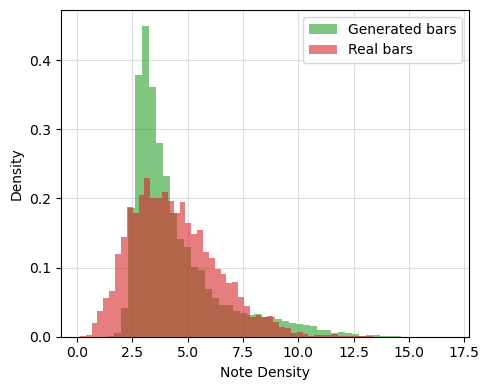

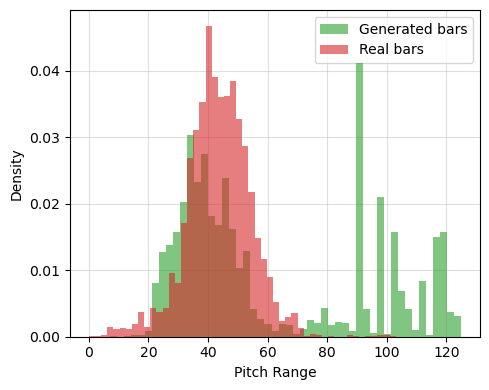

In [34]:
Real, Fake = [], []
for i in range(10000):
   bar = np.random.randint(len(Dataset)) - 10
   Bars, InstrumentCode, Cond1D = GenerateBars(bar)

   PolyConcBars = np.concatenate(Bars, axis = 2)
   RealBar = np.concatenate([Dataset[i + bar]['Bars'][0].to_dense() for i in range(8)], axis = 2)

   Real.append(RealBar)
   Fake.append(PolyConcBars)

CompareDistributions(Fake, Real)

### Random search on the hyperparameters space: $\lambda_1$ & $\lambda_2$

In [35]:
with open('RandomSearch.pkl', 'rb') as f:
   RandomSearch = pickle.load(f)

lambdas = {'λ1': np.logspace(-2, 0, 8), 'λ2': np.logspace(-1, 1, 8)}

HeatMap = np.zeros((len(lambdas['λ1']), len(lambdas['λ2'])))

Ratio = []
for i in range(len(RandomSearch)):
   v = list(RandomSearch[i].values())[0]
   r = v[0]/v[1]

   Ratio.append(r)

Ratio = np.reshape(Ratio, (8, 8))

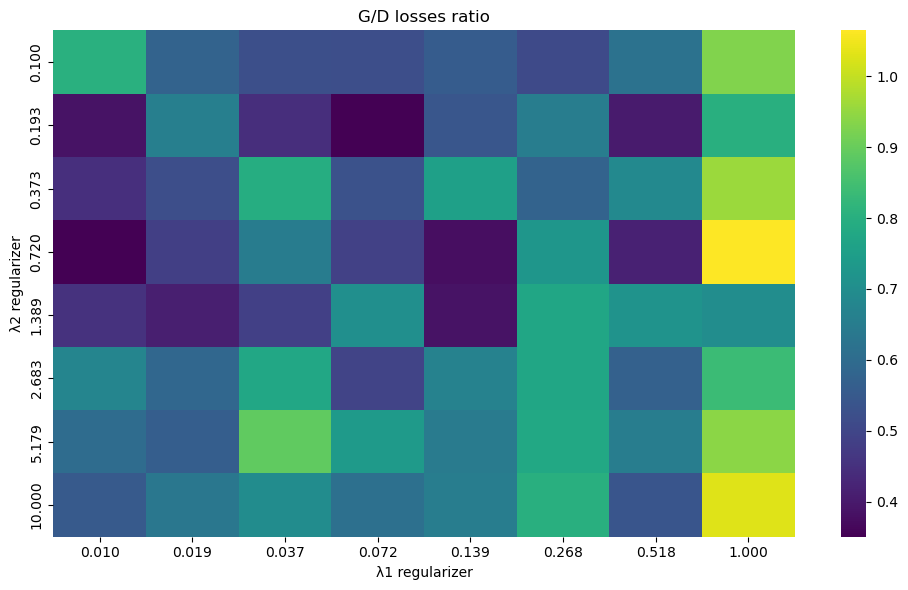

In [37]:
plt.figure(figsize=(10, 6))
sns.heatmap(
    Ratio,
    xticklabels=[f"{x:.3f}" for x in lambdas['λ1']],
    yticklabels=[f"{y:.3f}" for y in lambdas['λ2']],
    cmap="viridis", fmt=".2f"
)
plt.xlabel("λ1 regularizer")
plt.ylabel("λ2 regularizer")
plt.title("G/D losses ratio")
plt.tight_layout()
plt.show()